In [11]:
from pathlib import Path

import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.notebook import tqdm
from collections import namedtuple

from eval import read_run_dir
from new_eval import new_get_run_metrics, get_config, baseline_data, LoadInfo, filter_runs
from plot_utils import basic_plot, basic_plot2
from typing import List

%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

#models_dir = Path("../models")
device = "cpu" # Set to "cuda" if needed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
def plot_collection(ax, load_info_collection: List[LoadInfo], title: str, device: str = "cuda", yhigh_lim: float = float('inf'), baselines: List[str] = None, saveas: Path = None):
    metrics = {}
    for path, step, alt_path, alternative_pretrained_dir, alternative_name, name_addon in load_info_collection:
        conf = get_config(path / "config.yaml")
        name = alternative_name if alternative_name != "" else conf.wandb.name + "/" + conf.training.task + name_addon

        if alternative_pretrained_dir is not None:
            print("Alternative pretrained model dir: ", alternative_pretrained_dir)
            conf.model.pretrained_model_dir = str(alternative_pretrained_dir)

        if alt_path is not None:
            conf.training = get_config(alt_path).training

        #print(conf.model)

        metrics[name] = new_get_run_metrics(conf, path, step=step, include_noise=False, device=device)

    baselines_names = {'ridge_chebyshev_5': 'Chebyshev Ridge 5', 'chebyshev_5': 'Chebyshev 5'} #'ridge_chebyshev_5']) # "chebyshev_5"
    if baselines is not None:
        train_conf_path = load_info_collection[0].alternative_train_conf_path if load_info_collection[0].alternative_train_conf_path is not None else load_info_collection[0].path / "config.yaml"
        baseline_mets = baseline_data(train_conf_path, device=device, include_noise=False)
        print(baseline_mets.keys())
        metrics.update({baselines_names[key]: baseline_mets[key] for key in baselines if key in baseline_mets})
    
    ax = basic_plot2(ax, metrics, yhigh_lim=yhigh_lim)
    #plt.tight_layout()
    #plt.tight_layout()

Alternative pretrained model dir:  /home/mwilcoxson/Code/CS182Project/pos_models/base_model
Device: cpu
Keys: dict_keys(['model_state_dict', 'optimizer_state_dict', 'train_step'])
Lora Non-tranaible parameters: 7656705
Lora Trainable parameters: 12288 

Device: cpu
Alternative pretrained model dir:  /home/mwilcoxson/Code/CS182Project/models/kernel_linear_regression/small-1-11-5M-steps
Device: cpu
Keys: dict_keys(['model_state_dict', 'optimizer_state_dict', 'train_step'])
SoftPrompt Non-tranaible parameters: 7633665
SoftPrompt Trainable parameters: 512 

Device: cpu
Alternative pretrained model dir:  /home/mwilcoxson/Code/CS182Project/pos_models/base_model
Device: cpu
Keys: dict_keys(['model_state_dict', 'optimizer_state_dict', 'train_step'])
SoftPrompt Non-tranaible parameters: 7656705
SoftPrompt Trainable parameters: 12800 

Device: cpu
Device: cpu
dict_keys(['chebyshev_5', 'ridge_chebyshev_5'])
Alternative pretrained model dir:  /home/mwilcoxson/Code/CS182Project/pos_models/base_mode

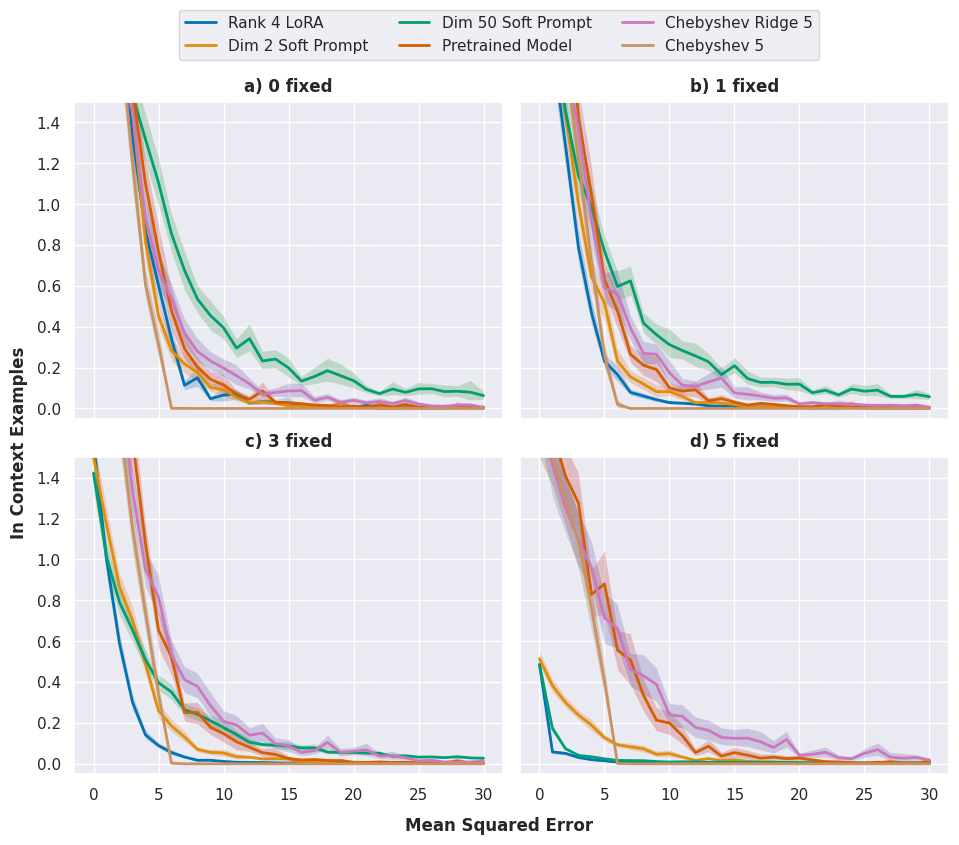

In [25]:
# Compare noisy examples with degree 5 and different sets of fixed coefficients
noisy_dir = Path("../noisy_stuff")
pos_dir = Path("../pos_models")

def plot_example(ax, i: int, title: str):
    
    # Get relevant lora run
    lora_run = LoadInfo(path=pos_dir / "lora_rk_4_pos_enc_copy" / f"lora{i}", step=-1,
                        alternative_name="Rank 4 LoRA",
                        alternative_pretrained_path="/home/mwilcoxson/Code/CS182Project/pos_models/base_model")
    lora_run_conf = get_config(lora_run.path / "config.yaml")
    
    # Get relevant 2 soft-prompt run
    soft2_run_path = filter_runs(pos_dir / "soft_prompting_dim_2_longer_training_copy", {"training": {"task_kwargs": lora_run_conf.training.task_kwargs}})
    assert len(soft2_run_path) == 1
    soft2_run = LoadInfo(path=soft2_run_path[0], step=-1,
                         alternative_name="Dim 2 Soft Prompt",
                         alternative_pretrained_path="/home/mwilcoxson/Code/CS182Project/models/kernel_linear_regression/small-1-11-5M-steps")
    
    # Get relevant 50 soft-prompt run
    soft50_run_path = filter_runs(pos_dir / "soft_prompting_dim_50_copy", {"training": {"task_kwargs": lora_run_conf.training.task_kwargs}})
    assert len(soft50_run_path) == 1
    soft50_run = LoadInfo(path=soft50_run_path[0], step=-1,
                          alternative_name="Dim 50 Soft Prompt",
                          alternative_pretrained_path="/home/mwilcoxson/Code/CS182Project/pos_models/base_model")
    

    load_info_collection = [lora_run,
                            soft2_run,
                            soft50_run,
                            LoadInfo(path=pos_dir / "base_model", step=-1,
                                    alternative_train_conf_path=lora_run.path / "config.yaml",
                                    alternative_name="Pretrained Model")
                            ]

    plot_collection(ax, load_info_collection, title=title, device=device, baselines=['ridge_chebyshev_5', "chebyshev_5"], saveas="./figs/soft_lora_"+title.replace(" ", "_"), yhigh_lim=1.5) # "chebyshev_5", 
    #plot_collection(load_info_collection, device=device, yhigh_lim=0.2, baselines=["chebyshev_5"])

fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
plot_example(axs[0, 0], 6, title="0 fixed coefficients, degree 5")
plot_example(axs[0, 1], 7, title="1 fixed coefficient, degree 5")
plot_example(axs[1, 0], 9, title="3 fixed coefficients, degree 5")
plot_example(axs[1, 1], 11, title="5 fixed coefficients, degree 5")

# Create a list of unique labels
handles, labels = [], []
for ax in axs.flat:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label not in labels:
            handles.append(handle)
            labels.append(label)

# Add the legend to the figure
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)


descriptions = ["a) 0 fixed", "b) 1 fixed", "c) 3 fixed", "d) 5 fixed"]

axs[0, 0].annotate(descriptions[0], xy=(0.5, 1.05), xycoords='axes fraction', ha='center', va='center', fontweight='bold')
axs[0, 1].annotate(descriptions[1], xy=(0.5, 1.05), xycoords='axes fraction', ha='center', va='center', fontweight='bold')
axs[1, 0].annotate(descriptions[2], xy=(0.5, 1.05), xycoords='axes fraction', ha='center', va='center', fontweight='bold')
axs[1, 1].annotate(descriptions[3], xy=(0.5, 1.05), xycoords='axes fraction', ha='center', va='center', fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(left=0.075, right=0.95, top=0.925, bottom=0.085)  # Adjust padding

# Add shared x and y axis labels
fig.text(0.5, 0.02, 'Mean Squared Error', ha='center', va='center', fontweight='bold')
fig.text(0.02, 0.5, 'In Context Examples', ha='center', va='center', rotation='vertical', fontweight='bold')

plt.savefig("./figs/soft_lora_all.png",bbox_inches='tight')
plt.show()